In [1]:
from random import choices

import numpy as np
import numpy.random as rand
import scipy.optimize
from scipy.stats import gamma
import matplotlib.pyplot as plt

In [2]:
# Don't touch this constants!
TOKENS_NUM = 3
TOKEN_PAIRS = ((1, 2), (1, 3), (2, 3))

# Variable parameters
EPOCHS_NUM = 10
OPT_STEPS_MAX = 3
UTILITY_RANGES = np.array([10, 1, 1000]) # Upper limit of coefficients in utility function for each token. Lower limit is 0.
SCALING_FACTOR = 100.0 # "Dirty" trick for proper work of optimization (SLSQP algorithm)
INCOME_VECTOR = np.array([1e5  / SCALING_FACTOR, 1e6 / SCALING_FACTOR, 1])
INCOME_LOW_MARGIN, INCOME_HIGH_MARGIN = 0.95, 1.05
AMM_INIT_LIQUIDITY = 100 * INCOME_VECTOR
GAMMA_PARAM = 1.5
RAND_TYPE = "custom"

# printing options
np.set_printoptions(suppress=True, precision=3)

In [3]:
# Random numbers generator with some distribution laws.
def randWrapper(size, type=None):
    if type == "custom":
        r = gamma.rvs(GAMMA_PARAM, size=size)
        saturation_flag = r > 10.0
        r[saturation_flag] = 10.0
        mirror_flag = np.random.random(size) > 0.8
        r[mirror_flag] = 20.0 - r[mirror_flag]
        return r
    else:
        return rand.random(size)

In [4]:
class User:
    def __init__(self):
        self.richness = User.getRichness()
        self.basket = np.zeros(TOKENS_NUM)

    def receiveIncome(self):
        self.basket += self.richness * INCOME_VECTOR * rand.uniform(INCOME_LOW_MARGIN, INCOME_HIGH_MARGIN, TOKENS_NUM)

    def seizeBasket(self):
        basket = self.basket
        self.basket = np.zeros(TOKENS_NUM)
        return basket

    @staticmethod
    def getRichness():
        return randWrapper(1, RAND_TYPE)
    
class Bank:
    def __init__(self, utilityFuncGenerator, amm):
        self.basket = np.zeros(TOKENS_NUM)
        self.utilityFunc = utilityFuncGenerator()
        self.amm = amm

    def deposit(self, basket):
        self.basket += basket

    def optimize(self, verbose=False):
        ''' Return True if optimization was successfull else return False.
        '''
        curr_utility = self.utility
        opt_res = None
        
        for unused in range(TOKENS_NUM):
            token_inds = set(range(TOKENS_NUM))
            sw0, sw1 = tuple(token_inds - {unused})

            def amm_rx_sw1(x):
                return self.amm.k / (self.amm.liq[sw0] + x) / self.amm.liq[unused] - self.amm.liq[sw1]

            def obj_func(x, sign=1.0):
                new_basket = np.zeros(TOKENS_NUM)
                new_basket[sw0] = self.basket[sw0] - x
                y = amm_rx_sw1(x)
                new_basket[sw1] = self.basket[sw1] - y
                new_basket[unused] = self.basket[unused]
                return sign * self.utilityFunc(new_basket)

            x0 = INCOME_VECTOR[sw0] / 20.0
            constr = [{'type': 'ineq', 'fun': lambda x: self.basket[sw1] - amm_rx_sw1(x)}]
            bnds = ((-self.amm.liq[sw0], self.basket[sw0]), )
        
            res = scipy.optimize.minimize(
                obj_func, 
                x0,
                method='SLSQP',
                args=(-1.0,),
                bounds=bnds, 
                constraints=constr,
                jac='3-point',
                tol=1e-6,
                options={'maxiter': 10000})
    
            if not res.success:
                # if verbose: print(f"Intermediate optimization stage failed: \n{res}")
                continue
    
            opt_utility = obj_func(res.x)
            if opt_utility > curr_utility:
                y = amm_rx_sw1(res.x)
                if abs(res.x) < 1e-4 or abs(y) < 1e-4:
                    continue # Too small for transaction!                
                curr_utility = opt_utility
                assert res.x * y < 0, f"Optimization failed: {res.x}*{y} >= 0!"
                if res.x > 0.0:
                    assert res.x <= self.basket[sw0], f"Optimization failed: transmitted more tokens than you had!" \
                        f"{sw0}: {res.x}, {sw1}: {y} ({self.basket[sw0]} max)"
                    opt_res = (res.x, sw0, sw1)
                else:
                    if y >= self.basket[sw1]:
                        y = self.basket[sw1]
                    opt_res = (y, sw1, sw0)
                
        if verbose:
            if opt_res is None:
                print("Optimization Failed!")                   
            else:
                print("Optimization succeed.")
        if opt_res is None:
            return False
        else:
            exchange_res = self.amm.swap(opt_res)
            self.deposit(exchange_res)
            return True

    @property
    def utility(self):
        return self.utilityFunc(self.basket)

class AMM:
    def __init__(self, x, y, z):
        self.liq = np.array([x, y, z])
        self.k =  x * y * z

    def swap(self, tx):
        """
            tx - transaction with swap parameters, tuple len(tx) == 3
            - tx[0] - amount of token which user sends to AMM
            - tx[1] - token index in range(TOKEN_NUMS) which user sends to AMM
            - tx[2] - token index in range(TOKEN_NUMS) which user wants to get

            Return ret - receipt with information about swap, list len(ret) = 3. ret contains balance change of user.            
        """
        token_inds = {0, 1, 2}
        tx_ind = tx[1]
        rx_ind = tx[2]
        swap_pair = {tx_ind, rx_ind}
        unused_ind = token_inds - swap_pair
        unused_ind = unused_ind.pop()

        res = self.k / self.liq[unused_ind] / (self.liq[tx_ind] + tx[0]) - self.liq[rx_ind]
        assert res < 0, f"Oops! Error during swap! tx={self.liq[tx_ind]}, rx={res}"
        self.liq[tx_ind] += tx[0]
        self.liq[rx_ind] += res
        ret = np.zeros(3)
        ret[tx_ind] = -tx[0]
        ret[rx_ind] = -res
        return ret

    def getPrices(self):
        """
            Return exch_rate - pairs of tokens' exchange rate, tuple len(exch_rate == 3)
            - exch_rate[0] - exchange rate of "token 2 vs token 1" pair
            - exch_rate[1] - exchange rate of "token 3 vs token 1" pair
            - exch_rate[2] - exchange rate of "token 3 vs token 2" pair
        """
        return (self.liq[0]**2 * self.liq[2] / self.k, 
                SCALING_FACTOR * self.liq[0]**2 * self.liq[1] / self.k, 
                SCALING_FACTOR * self.liq[1]**2 * self.liq[0] / self.k)

In [5]:
def simulate(epochs_num, opt_steps_max, amm_init_liquidity, utility_func_gen, verbose=False):
    amm = AMM(*amm_init_liquidity)
    bank = Bank(utility_func_gen, amm)

    users = []
    prices_list = []

    for epoch in range(epochs_num):
        if verbose: print(f"epoch {epoch+1}:")
        if verbose: print(f"AMM basket: {amm.liq}")
        if verbose: print(f"Prices: {amm.getPrices()}")
        user = User()
        users.append(user)
        for user in users:
            user.receiveIncome()
            basket = user.seizeBasket()
            bank.deposit(basket)
        if verbose: print(f"Utility before optimization: {bank.utility}")
        if verbose: print(f"Basket before optimization: {bank.basket}")
        for ii in range(opt_steps_max):
            if not bank.optimize(verbose):
                if verbose: print(f"{ii} optimization steps was successfull.")
                break
            if verbose and ii == opt_steps_max - 1: print(f"{ii+1} optimization steps was successfull.")
        if verbose: print(f"Utility after optimization: {bank.utility}")
        if verbose: print(f"Basket after optimization: {bank.basket}")
        if verbose: print("=====================")
        prices = amm.getPrices()
        prices_list.append(prices)

    return prices_list

def plotPrices(prices_list):
    epochs_num = len(prices_list)
    prices_list = np.array(prices_list)
    epoch_inds = np.arange(1, epochs_num + 1) 
    fig, ax = plt.subplots(1, TOKENS_NUM, figsize=(15, 4))
    plt.tight_layout(w_pad=5.0)
    for fig_ind, token_pair in enumerate(TOKEN_PAIRS):
        ax[fig_ind].set_title(f"Token {token_pair[1]} price vs Token {token_pair[0]} price")
        ax[fig_ind].set_xlabel(f"epoch index")
        ax[fig_ind].set_ylabel(f"Token {token_pair[1]} price")
    for fig_ind in range(TOKENS_NUM):
        ax[fig_ind].plot(epoch_inds, prices_list[:, fig_ind], marker='o', linestyle='--', linewidth=0.75)

In [6]:
def dummy_f(x):
    return x

def log_f(x):
    return np.log(x + 1)

def utilityFuncGen():
    funcs_store = [dummy_f, log_f]
    coeffs = UTILITY_RANGES * randWrapper(TOKENS_NUM)
    funcs = choices(funcs_store, k=TOKENS_NUM)
    print(f"Coefficients choosen: {coeffs}")
    print(f"Function choosen: {funcs}")

    def utilityFunc(x, sign=1.0):
        scaled_x = np.array([SCALING_FACTOR * x[0], SCALING_FACTOR * x[1], x[2]])
        proc_x = np.array([func(x) for func, x in zip(funcs, scaled_x)])
        return sign * np.sum(coeffs * proc_x)
    return utilityFunc
    
prices_list = simulate(EPOCHS_NUM, OPT_STEPS_MAX, AMM_INIT_LIQUIDITY, utilityFuncGen, verbose=True)

Coefficients choosen: [  1.485   0.906 544.112]
Function choosen: [<function log_f at 0x000001210A65A3A0>, <function log_f at 0x000001210A65A3A0>, <function dummy_f at 0x000001210A65A0D0>]
epoch 1:
AMM basket: [ 100000. 1000000.     100.]
Prices: (0.1, 100000.0, 1000000.0)
Utility before optimization: 363.92887335919585
Basket before optimization: [ 642.806 6310.03     0.616]
Optimization succeed.
Optimization succeed.
Optimization succeed.
3 optimization steps was successfull.
Utility after optimization: 1034.6294450137816
Basket after optimization: [ 2.76  16.89   1.874]
epoch 2:
AMM basket: [ 100640.046 1006293.14       98.743]
Prices: (0.10001066506353294, 101921.58460532861, 1019107.1576274564)
Utility before optimization: 1657.9801743708024
Basket before optimization: [ 1097.052 10984.812     2.992]
Optimization succeed.
Optimization succeed.
Optimization succeed.
3 optimization steps was successfull.
Utility after optimization: 2794.1848258389623
Basket after optimization: [ 2.8

C:\Users\Hypotalamus\AppData\Local\Temp\ipykernel_7728\2516674125.py:5: RuntimeWarning: invalid value encountered in log
  return np.log(x + 1)


Optimization succeed.
Optimization succeed.
3 optimization steps was successfull.
Utility after optimization: 177901.14156011151
Basket after optimization: [103.662 635.865 326.913]
epoch 8:
AMM basket: [ 335594.113 3373598.922       8.833]
Prices: (0.09947658881333982, 3799462.0949339513, 38194535.4204229)
Utility before optimization: 221718.91068591436
Basket before optimization: [ 77262.427 799553.314    407.414]
Optimization succeed.
Optimization succeed.
Optimization succeed.
3 optimization steps was successfull.
Utility after optimization: 223349.60804698506
Basket after optimization: [ 193.854 1195.396  410.439]
epoch 9:
AMM basket: [ 412662.685 4171956.839       5.809]
Prices: (0.09891345981791776, 7104445.815143873, 71824864.161277)
Utility before optimization: 266196.8113896503
Basket before optimization: [ 79355.151 776868.646    489.158]
Optimization succeed.
Optimization succeed.
Optimization succeed.
3 optimization steps was successfull.
Utility after optimization: 266960

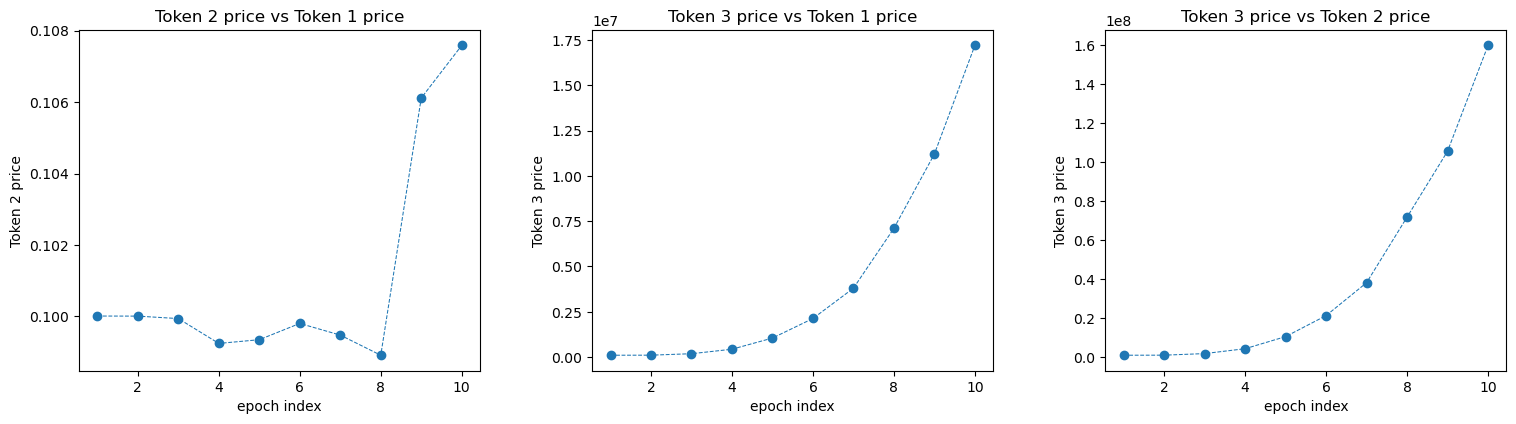

In [7]:
plotPrices(prices_list)